# DS5230 Homework 2
# Implementing and Comparing Clustering Algorithms
To help you with the implementation, we provide some guidance code in this notebook. We will walk you through the exercise step by step, and you need to fill in the missing parts to answer each question. In the template, '...' denotes the missing pieces you need to code up. Please be aware of the following:
1. '...' does NOT imply that it is literally a fill-in-the-blank quiz, i.e. sometimes you need to write more than one line of command to make it work. On the other hand, you can implement it in any way you like, as long as the whole the implementation works.
2. You may also change some of the existing code to support your own preferred implementation.
3. We strongly encourage you to NOT change the pipeline in the implementation. For example, you are required to code/write your answer for each question in the correspodning block out. Additionally, you should make sure that the exisiting print satatements in the code runs, so that we can understand your results better.

In [467]:
%matplotlib inline
import math
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from pandas import DataFrame
from IPython.display import display
from collections import namedtuple, defaultdict
from sklearn.metrics import normalized_mutual_info_score, calinski_harabasz_score, silhouette_score
from tqdm import notebook

## Data Loading and Parsing
We firstly load the 3 datasets and parse each of them as a tuple of (datapoints, labels). We store the parsed data in a dictionary called <em>data_dict</em>.
Then we visualize the 2d datapoints.

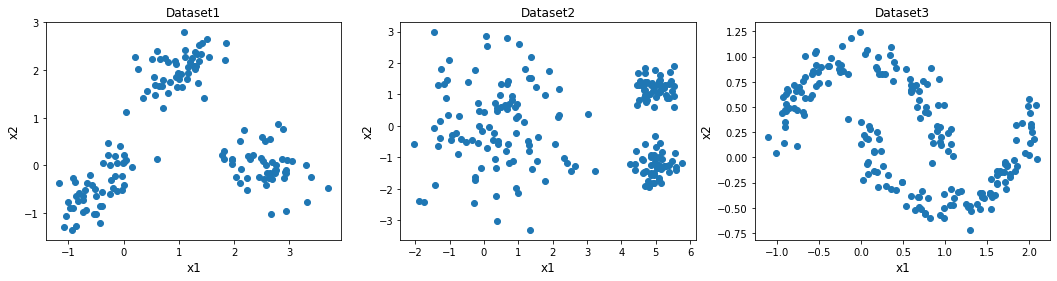

In [243]:
## you need to change the directory to your local dirs
directory = './gmm_datasets/'

def load_and_parse_dataset(directory, file):
    """
    load raw data and parse it into a tuple of (input, labels)
    """
    dataset = np.loadtxt(directory + file,
                         dtype = {'names': ('x1', 'x2', 'label'), 'formats': (float, float, int)},
                         delimiter="\t")
    inputs, labels = [], []
    for x1, x2, l in dataset:
        inputs.append([x1, x2])
        labels.append(l)
    return (np.array(inputs), np.array(labels))

def visualize_raw_data(data_dict):
    """ quick dataviz function that doesn't pollute global scope """
    fig = plt.figure(figsize=(18,4))
    num_cols = len(data_dict.keys())
    for i, (inputs, labels) in data_dict.items():
        ax = fig.add_subplot(1,num_cols,i)
        ax.scatter(inputs[:,0], inputs[:,1])
        ax.set_xlabel('x1', fontsize=12)
        ax.set_ylabel('x2', fontsize=12)
        ax.set_title('Dataset%d' % i, fontsize=12)
        
data_dict = {}
for ix in range(1,4):
    data_dict[ix] = load_and_parse_dataset(directory, "dataset{}.txt".format(ix)) 
visualize_raw_data(data_dict)

## Implement DBSCAN Algorithm
TODO: In the following code block, you are required to implemnet DBSCAN algorithm. Read the comments which can help you to implement the whole algorithm.

You are welcome to wipe out this framework and come up with your own. For instance, an alternative is that you can find neighbors of a point only when it is visited, rather than computing all neighbors of all points beforehand. Another example is to use list/stack or other advanced data struture to perform this depth-first-search-style scanning. 

BUT, we will on longer be able to help you with coding if you code it up from scratch. More importantly, You are NOT allowed to copy open-sourced implementation for replacement. That results in violation of academic integrity.

In [244]:
import numpy as np
from sklearn.metrics.pairwise import euclidean_distances

In [245]:
from collections import deque
def form_cluster(cluster_label, pred_labels, i, neighbors_indices, is_core):
    dq = deque()
    visited = set()
    
    dq.append(i)
    visited.add(i)
    
    while dq:
        point = dq.popleft()
        pred_labels[point] = cluster_label
        
        for neighbour in neighbors_indices[point]:
            if neighbour not in visited:
                # if its a core point, put into queue
                if is_core[neighbour] == 1:
                    dq.append(neighbour)
                    
                # if its a border point, simply label it
                else:
                    pred_labels[neighbour] = cluster_label
                
                # adding neighbour to visited
                visited.add(neighbour)
    
    return pred_labels

In [246]:
def DBSCAN(inputs, eps, min_points):
    """
    DBSCAN algorithm
    cluster labels are positive integers, i.e. 1,2,3,...
    noise label is -1

    arguments
        inputs : np.ndarray
        eps : float
        min_points : int
    return 
        pred_labels : np.ndarray
    """
    print("running with eps = {}, and min_pts = {}".format(eps, min_points))
    cluster_label = 0
    # initially all points are labeled as noise
    pred_labels = np.full(len(inputs), -1)
    # for each input point, compute and store indices of its neighbor, and 
    # check whether it is a core point 
    neighbors_indices, is_core = find_neighbors(inputs, eps, min_points) 
    for i in range(len(pred_labels)):
        # skip the point if it has already been assigned to a cluster, or it is a border point
        if pred_labels[i] != -1 or is_core[i]==0: 
            continue
        # initiate a new cluster if the point is an unassigned core point
        else: 
            cluster_label+=1
            pred_labels = form_cluster(cluster_label, pred_labels, i, neighbors_indices, is_core)
            
    return pred_labels

def find_neighbors(inputs, eps, min_points): 
    """
    For each point p, find indices of its epsilon-neighbors and determine whether it is a core point as
    1 - core point
    0 - non-core point
    return 
        neighbors_indices : list
        is_core : np.ndarray
    """
    pairwise_dists = euclidean_distances(inputs)
    neighbors_indices = []
    is_core = np.zeros(len(inputs))
    
    for i, p in enumerate(inputs):
        curr_indices = []
        dists = pairwise_dists[i]
        
        for j, dist in enumerate(dists):
            if dist <= eps:
                curr_indices.append(j)
        
        # appending neighbour indices for current point
        neighbors_indices.append(curr_indices)

        # finding if current point is core or not
        if len(curr_indices) >= min_points:
            is_core[i] = 1
            
    return neighbors_indices, is_core

## Run DBSCAN with gridsearch
TODO: For each dataset, you need to run DBSCAN with different hyper-parameters. we provide the function called <em>gridsearch</em>, which can help to iterate over values of hyper-parameters. But feel free to write your own gridsearch function.

In [247]:
################gridsearch function###############
clustering_results = namedtuple("results", ["eps", "minpts"])
def gridsearch(inputs, all_eps, all_minpts):
    """
    perform gridsearch for one dataset with different hyper-parameters
    arguments
        inputs : np.ndarray
        all_eps : list
        all_minpts : list
    return
        gridsearch_results : dict
    """
    gridsearch_results = {}
    for e in all_eps:
        for p in all_minpts:
            gridsearch_results[clustering_results(e, p)] = DBSCAN(inputs, e, p)
    return gridsearch_results
################Hyper-parameters###################
list_all_eps = [[0.2, 0.3, 0.4], # for dataset1
                [0.8, 0.9, 1.0], # for datset2
                [0.15, 0.2, 0.25]] # for dataset3
list_all_minpts = [[2, 3, 4], # for dataset1
                   [3, 4, 5], # for dataset2
                   [5, 6, 7]] # for dataset3
############Run DBSCAN for each dataset############
results_dict = {}
for i in range(3):
    print("==============Running DBSCAN for dataset {}==============".format(i+1))
    results_dict[i+1] = gridsearch(data_dict[i+1][0], list_all_eps[i], list_all_minpts[i])
    print("=============Completed DBSCAN for dataset {}=============".format(i+1))

==============Running DBSCAN for dataset 1==============
running with eps = 0.2, and min_pts = 2
running with eps = 0.2, and min_pts = 3
running with eps = 0.2, and min_pts = 4
running with eps = 0.3, and min_pts = 2
running with eps = 0.3, and min_pts = 3
running with eps = 0.3, and min_pts = 4
running with eps = 0.4, and min_pts = 2
running with eps = 0.4, and min_pts = 3
running with eps = 0.4, and min_pts = 4
=============Completed DBSCAN for dataset 1=============
==============Running DBSCAN for dataset 2==============
running with eps = 0.8, and min_pts = 3
running with eps = 0.8, and min_pts = 4
running with eps = 0.8, and min_pts = 5
running with eps = 0.9, and min_pts = 3
running with eps = 0.9, and min_pts = 4
running with eps = 0.9, and min_pts = 5
running with eps = 1.0, and min_pts = 3
running with eps = 1.0, and min_pts = 4
running with eps = 1.0, and min_pts = 5
=============Completed DBSCAN for dataset 2=============
==============Running DBSCAN for dataset 3==========

### Q1.a Compute Metric Scores
TODO : Now you need to compute NMI, CH, SC scores using metrics functions in sklearn. Report the numbers in form of dataframes, where rows represent different runs, columns represent differnt scores.

To compute the metrics, you also need to filter out the noise points from the inputs and labels. The function <em>filter_out_noise</em> is supposed to take care of this filitering.

In [248]:
results_dict[1].keys()

dict_keys([results(eps=0.2, minpts=2), results(eps=0.2, minpts=3), results(eps=0.2, minpts=4), results(eps=0.3, minpts=2), results(eps=0.3, minpts=3), results(eps=0.3, minpts=4), results(eps=0.4, minpts=2), results(eps=0.4, minpts=3), results(eps=0.4, minpts=4)])

In [257]:
def filter_out_noise(inputs, true_labels, pred_labels): 
    """
    filter out noise points from the input data, 
    arguments
        inputs : np.ndarray
        true_labels : np.ndarray
        pred_labels : np.ndarray
    return 
        filtered_inputs : np.ndarray
        filtered_true_label : np.ndarray
        filtered_pred_labels : np.ndarray
    """
    idx_tokeep = [idx for idx, label in enumerate(pred_labels) if label!=-1]
    
    filtered_inputs = [inputs[idx] for idx in idx_tokeep]
    filtered_true_labels = [true_labels[idx] for idx in idx_tokeep]
    filtered_pred_labels = [pred_labels[idx]for idx in idx_tokeep]
    
    return filtered_inputs, filtered_true_labels, filtered_pred_labels

def evaluation(data_dict, results_dict): 
    """
    compute the NMI, SC, and CH scores for the clustering results.
    metrics_dict is a dictionary where key=dataset_index : value=dataframe_of_dataset_index
    where the dataframe is like
    (header) eps  minpts  NMI  CH  SC
             ...  ...     ...  ..  ..
             ...  ...     ...  ..  ..
             ...  ...     ...  ..  ..
    """
    metrics_dict = {}
    for dataset_index, (inputs, true_labels) in data_dict.items():
        gridsearch_results = results_dict[dataset_index]
        metrics = defaultdict(list)
        for param, pred_labels in gridsearch_results.items():
            filtered_inputs, filtered_true_labels, filtered_pred_labels = filter_out_noise(inputs, 
                                                                                           true_labels, 
                                                                                           pred_labels)
            eps, minpts = param
            metrics['eps'].append(eps)
            metrics['minpts'].append(minpts)
            metrics['NMI'].append(normalized_mutual_info_score(filtered_true_labels, 
                                                               filtered_pred_labels))
            metrics['CH'].append(calinski_harabasz_score(filtered_inputs, 
                                                         filtered_pred_labels))
            metrics['SC'].append(silhouette_score(filtered_inputs, 
                                                  filtered_pred_labels))
            
        metrics_dict[dataset_index] = DataFrame.from_dict(metrics)
    return metrics_dict
        
metrics_dict = evaluation(data_dict, results_dict) 
for dataset_index, df in metrics_dict.items():
    print("==============Dataset {}==============".format(dataset_index))
    display(df)

==============Dataset 1==============


,eps,minpts,NMI,CH,SC
0,0.2,2,0.758157,307.914718,0.444011
1,0.2,3,0.787648,372.663018,0.488880
2,0.2,4,0.802404,390.593726,0.478121
3,0.3,2,0.877166,223.381972,0.422362
4,0.3,3,0.964520,471.476090,0.589226
5,0.3,4,1.000000,681.182571,0.762721
6,0.4,2,0.974782,445.759824,0.626530
7,0.4,3,1.000000,646.432430,0.735887
8,0.4,4,1.000000,655.625678,0.737772


==============Dataset 2==============


,eps,minpts,NMI,CH,SC
0,0.8,3,0.968519,287.948356,0.529058
1,0.8,4,0.960980,305.493602,0.514939
2,0.8,5,1.000000,423.419608,0.647111
3,0.9,3,0.968552,281.032893,0.523586
4,0.9,4,1.000000,392.187136,0.634593
5,0.9,5,1.000000,406.620537,0.639553
6,1.0,3,0.768396,239.864765,0.492780
7,1.0,4,0.795841,442.016357,0.610925
8,1.0,5,0.795841,442.016357,0.610925


==============Dataset 3==============


,eps,minpts,NMI,CH,SC
0,0.15,5,0.526835,392.251414,0.509310
1,0.15,6,0.487830,355.396351,0.474848
2,0.15,7,0.503369,377.532449,0.520215
3,0.20,5,0.800908,184.086375,0.376958
4,0.20,6,0.804871,175.307652,0.377236
5,0.20,7,0.804871,175.307652,0.377236
6,0.25,5,1.000000,162.813208,0.362299
7,0.25,6,0.800185,184.156686,0.373850
8,0.25,7,0.800908,182.115087,0.373759


## Q1.b Visualizing Best Results
TODO : You need to make scatter plots based on the best results for each dataset. You select the <em>best</em> results by a specific priority of metrics: NMI > CH > SC. i.e. In each table,
<ol>
<li>Firstly look for the row(s) with the highest NMI score. If the candiate is unique, pick it up as best result. </li> 
<li>If there are more than one candidates that have the highest NMI score, pick up the one with hightest CH score among those candidates from step 1. </li>
<li>If there are more than one candidates that have the highest NMI score and highest CH score, pick up the one with the highest SC score among those candidates from step 2.</li>
<li>If there are still more than one candidates by far, select the first one as the best result.
</ol>
In each scatter plot, you need to use shapes to represent true labels and use colors to represent the cluster assignments by DBSCAN.

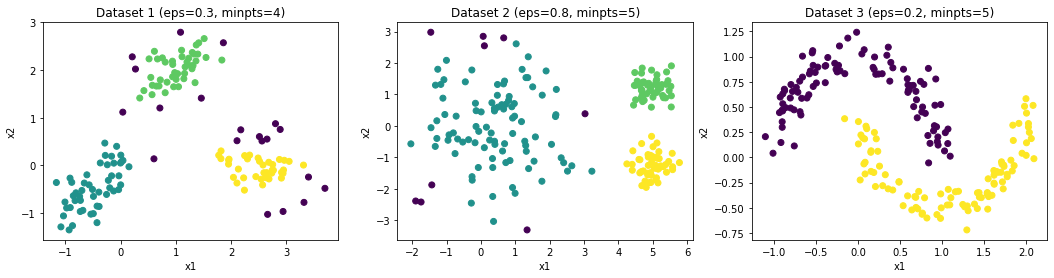

In [283]:
def select_best_results(df, scores=['NMI', "CH", "SC"]):
    for score in scores:
        values = df[score].values
        max_score = np.max(values)
        candidates = [idx for idx, value in enumerate(values) if value==max_score]
        
        # if candidate is unique
        if len(candidates)==1:
            return df.iloc[candidates[0]]
        
    # return the first row if there are multiple candidates at the end
    return df.iloc[0]

def plot_cluster_results(data_dict, results_dict, metrics_dict, shapes=['o', '^', '*'], colors = ['#0077BB', '#AA3377', '#EE7733']): 
    """
    visualize the best results for each dataset as
    """
    fig = plt.figure(figsize=(18,4))
    for dataset_index, (inputs, true_labels) in data_dict.items():
        ax = fig.add_subplot(1, len(data_dict.keys()), dataset_index)
        df = metrics_dict[dataset_index]
        best_row = select_best_results(df)
        best_eps, best_minpts = best_row['eps'], best_row['minpts']
        pred_labels  = results_dict[dataset_index][clustering_results(best_eps, best_minpts)]
        
        # scatter plot
        plt.scatter(inputs[:,0], inputs[:,1], c=pred_labels)
        
        ax.set_title('Dataset %d (eps=%.1f, minpts=%d)' % (dataset_index, best_eps, best_minpts))
        ax.set_xlabel('x1')
        ax.set_ylabel('x2')
                
plot_cluster_results(data_dict, results_dict, metrics_dict)

## Implement K-Means Algorithm
TODO: You need to implement K-Means algorithm. Read the comments which can help you with coding.

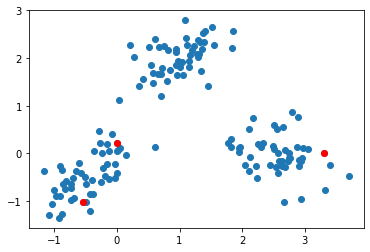

In [195]:
# TO Delete

def dist(x, y):
    x, y = np.array(x), np.array(y)
    return np.linalg.norm(x-y)

def initialize_means(inputs, K):
    """
    Initializes means based on K-Means++ strategy
    """
    means = []
    
    # choosing a random observation as the initial mean
    idx = np.random.choice(range(len(inputs)))
    means.append(list(inputs[idx]))
    # continue until we have found K means
    while len(means)<K:
        min_dists = defaultdict(lambda: float('inf')) # dictionary to store min distances for each x
        for x in inputs:
            x = list(x)
            # skip if x is already selected as a centroid
            if x in means:
                continue
            for mean in means:
                curr_dist = dist(x, mean)
                if curr_dist<min_dists[tuple(x)]:
                    min_dists[tuple(x)] = curr_dist
        
        # calculating denominator for normalization
        denominator = sum([dist**2 for dist in list(min_dists.values())])
        
        # calculating probability for selecting new mean
        probs = [dist**2/denominator for dist in list(min_dists.values())]
        
        # sample out new mean
        new_mean_idx = np.random.choice(range(len(min_dists.keys())), p=probs)
        new_mean = list(list(min_dists.keys())[new_mean_idx])
        means.append(new_mean)
        
    return means

means = initialize_means(data_dict[1][0], 3)

plt.scatter(data_dict[1][0][:,0], data_dict[1][0][:,1]);
plt.scatter(np.array(means)[:,0], np.array(means)[:,1], c='red')

In [209]:
def plot(inputs, means):
    plt.figure()
    plt.scatter(inputs[:,0], inputs[:,1]);
    plt.scatter(np.array(means)[:,0], np.array(means)[:,1], c='red')

In [501]:
def K_Means(inputs, K, maxiter=100, init_means=None): 
    """
    K-Means algorithm
    """
    N, D = inputs.shape
    SSEs = []
    converged = False
    # if init_means is specified
    if init_means is not None:
        means = init_means
    # sample means from Normal distribution using
    # empirical mean and standard deviation
    else:
        means = initialize_means(inputs, K)
    
    # update assignments
    assignments = update_assignments(inputs, means, K)
    #plot(inputs, means)
    
    # tracking sses
    SSEs.append(compute_sse(inputs, assignments, means))
    
    for i in range(maxiter):
        # iteratively update means and assignments
        means = update_means(inputs, means, assignments)
        assignments = update_assignments(inputs, means, K)
        SSEs.append(compute_sse(inputs, assignments, means))
        # terminate the program if it converges in the sense that 
        # the sse stays the same as that in previous iteration
        if len(SSEs)>=2 and SSEs[-1] == SSEs[-2]:
            break
        
        #plot(inputs, means)
    
    # cluster ids are 0-indexed. Make them 1-indexed
    assignments = [x+1 for x in assignments]
    return means, assignments, SSEs[-1]

def dist(x, y):
    x, y = np.array(x), np.array(y)
    return np.linalg.norm(x-y)

def initialize_means(inputs, K):
    """
    Initializes means based on K-Means++ strategy
    """
    means = []
    
    # choosing a random observation as the initial mean
    idx = np.random.choice(range(len(inputs)))
    means.append(list(inputs[idx]))
    # continue until we have found K means
    while len(means)<K:
        min_dists = defaultdict(lambda: float('inf')) # dictionary to store min distances for each x
        for x in inputs:
            x = list(x)
            # skip if x is already selected as a centroid
            if x in means:
                continue
            for mean in means:
                curr_dist = dist(x, mean)
                if curr_dist<min_dists[tuple(x)]:
                    min_dists[tuple(x)] = curr_dist
        
        # calculating denominator for normalization
        denominator = sum([dist**2 for dist in list(min_dists.values())])
        
        # calculating probability for selecting new mean
        probs = [dist**2/denominator for dist in list(min_dists.values())]
        
        # sample out new mean
        new_mean_idx = np.random.choice(range(len(min_dists.keys())), p=probs)
        new_mean = list(list(min_dists.keys())[new_mean_idx])
        means.append(new_mean)
        
    return means
    
# def update_assignments(inputs, means, K): 
#     """
#     update the cluster assignments, which are represented in one-hot vectors  
#     """
#     assignments = [] # 0-indexed cluster assignments for each point
#     for x in inputs:
#         curr_dists = [] #distances of current point from all the means
#         for mean in means:
#             curr_dists.append(dist(x, mean))
        
#         # select the index corresponding to the closest mean
#         # and call it the cluster number
#         cluster_id = np.argmin(curr_dists)
#         assignments.append(cluster_id)
    
#     return assignments

def update_assignments(inputs, means, K): 
    """
    update the cluster assignments, which are represented in one-hot vectors  
    """
    assignments = [] # 0-indexed cluster assignments for each point
    for x in inputs:
        curr_dists = ((x - means) ** 2).sum(axis = 1)
        
        # select the index corresponding to the closest mean
        # and call it the cluster number
        cluster_id = np.argmin(curr_dists)
        assignments.append(cluster_id)
    
    return assignments
        
def update_means(inputs, means, assignments):
    """
    update the cluster means 
    make sure that you take care of the edge case where
    empty cluster shows up in the update step
    """
    for idx, _ in enumerate(means):
        # select points that have the same assignment as idx
        cluster_members = [inputs[i] for i, cluster_id in enumerate(assignments) if idx==cluster_id]
        #print('cluster members ', cluster_members)
        new_mean = np.mean(cluster_members, axis=0)
        means[idx] = new_mean
    
    return means

def compute_sse(inputs, assignments, means): 
    """
    compute the SSE as loss function 
    """
    sse = 0
    for idx, assignment in enumerate(assignments):
        cluster_mean = means[assignment]
        x = inputs[idx]
        distance = dist(x, cluster_mean)
        sse += distance**2
    
    return sse

In [236]:
K_Means(data_dict[1][0], 3);

## Run K-Means with multiple restarts and gridsearch
TODO: you need to implement a function the supports multiple restarts of K-Means. we provide the function called <em>gridsearch</em>, which can help to iterate over values of hyper-parameters. But feel free to write your own gridsearch function.

In [492]:
def restarts(inputs, K, num_restarts=100):
    """
    run the k-means with multiple iterations
    """
    print("running with K={} and num_restarts={}".format(K, num_restarts))
    results = []
    sses = []
    for i in range(num_restarts): 
        means, assignments, sse = K_Means(inputs, K)
        # store the results at each restart
        results.append((means, assignments))
        sses.append(sse)
    # pick up the best results and 
    # return its (means, assigments), sse
    best_idx = np.argmin(sses)
    return results[best_idx], sses[best_idx]

def gridsearch(inputs, Ks, num_restarts=100):
    """
    perform grisearch with different K values
    """
    gridsearch_results = {}
    gridsearch_sses = {}
    for k in Ks:
        results, sses = restarts(inputs, k, num_restarts=num_restarts)
        gridsearch_results[k] = results
        gridsearch_sses[k] = sses
    return gridsearch_results, gridsearch_sses

sses_dict = {}
results_dict = {}
Ks = [2,3,4,5]
for i in range(3):
    print("==============Running K-Means for dataset {}==============".format(i+1))
    results, sses = gridsearch(data_dict[i+1][0], Ks)
    results_dict[i+1] = results
    sses_dict[i+1] = sses
    print("=============Completed K-Means for dataset {}=============".format(i+1))

==============Running K-Means for dataset 1==============
running with K=2 and num_restarts=100
running with K=3 and num_restarts=100
running with K=4 and num_restarts=100
running with K=5 and num_restarts=100
=============Completed K-Means for dataset 1=============
==============Running K-Means for dataset 2==============
running with K=2 and num_restarts=100
running with K=3 and num_restarts=100
running with K=4 and num_restarts=100
running with K=5 and num_restarts=100
=============Completed K-Means for dataset 2=============
==============Running K-Means for dataset 3==============
running with K=2 and num_restarts=100
running with K=3 and num_restarts=100
running with K=4 and num_restarts=100
running with K=5 and num_restarts=100
=============Completed K-Means for dataset 3=============


## Q2.a Computing Metric Scores
TODO : Now you need to report NMI, CH, SC scores and the SSE in form of dataframes, where rows represent different runs, columns represent differnt scores.

Note that CH and SC cannot be computed when K=1. In this case, put a N/A or equivalent symbol as the corresponding values in the dataframe. 

In [493]:
def evaluation(data_dict, results_dict, sses_dict): 
    """
    compute the NMI, SC, and CH scores for the clustering results 
    metrics_dict is a dictionary where key=dataset_index : value=dataframe_of_dataset_index
    where the dataframe is like
    (header) K    SSE     NMI  CH  SC
             ...  ...     ...  ..  ..
             ...  ...     ...  ..  ..
             ...  ...     ...  ..  ..
    """
    metrics_dict = {}
    for dataset_index, (inputs, true_labels) in data_dict.items():
        metrics = defaultdict(list)
        for i, K in enumerate(Ks):
            means, assignments = results_dict[dataset_index][K]
            sse = sses_dict[dataset_index][K]
            
            metrics['K'].append(K)
            metrics['SSE'].append(sse)
            metrics['NMI'].append(normalized_mutual_info_score(assignments, true_labels))
            metrics['CH'].append(calinski_harabasz_score(inputs, assignments))
            metrics['SC'].append(silhouette_score(inputs, assignments))

        metrics_dict[dataset_index] = DataFrame.from_dict(metrics)
    return metrics_dict
        
metrics_dict = evaluation(data_dict, results_dict, sses_dict) 
for dataset_index, df in metrics_dict.items():
    print("==============Dataset {}==============".format(dataset_index))
    display(df)

==============Dataset 1==============


,K,SSE,NMI,CH,SC
0,2,215.943499,0.699401,163.903539,0.533083
1,3,49.698823,1.000000,599.538583,0.722205
2,4,38.113363,0.882051,532.436242,0.632678
3,5,31.059718,0.806182,494.890267,0.517864


==============Dataset 2==============


,K,SSE,NMI,CH,SC
0,2,476.708922,0.721911,439.533041,0.607343
1,3,319.774560,0.900887,374.306140,0.616991
2,4,204.964340,0.802282,423.935212,0.541759
3,5,152.046962,0.757044,443.388862,0.544990


==============Dataset 3==============


,K,SSE,NMI,CH,SC
0,2,76.726241,0.239999,335.787217,0.509354
1,3,47.177075,0.405314,333.369090,0.467488
2,4,32.483334,0.389026,350.693292,0.468915
3,5,24.021502,0.487789,371.029628,0.488992


## Q2.b Visualizing Results
TODO : You need to make scatter plots for all K=1,2,3,4,5. In each scatter plot, you need to use shapes to represent true labels and use colors to represent the cluster assignments by K-Means. In addition, plot the cluster means by setting <em>color='k', marker='x' markersize=100</em>.

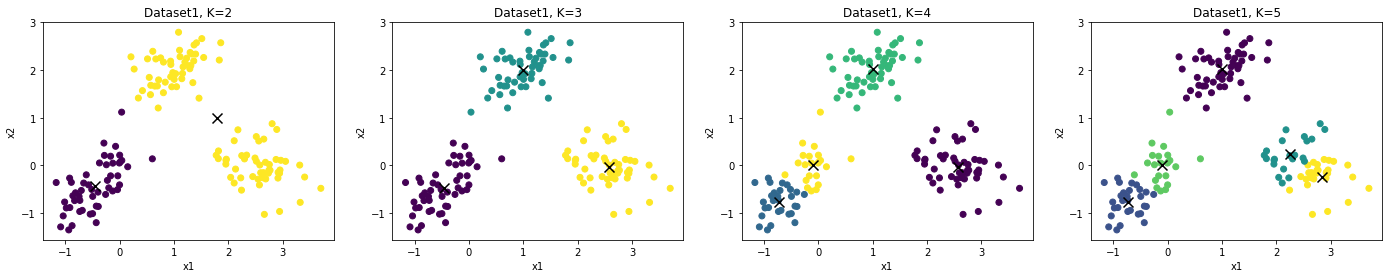

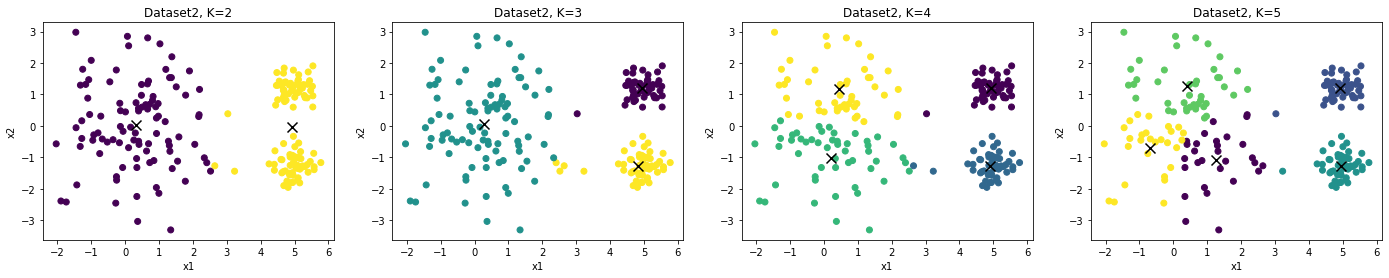

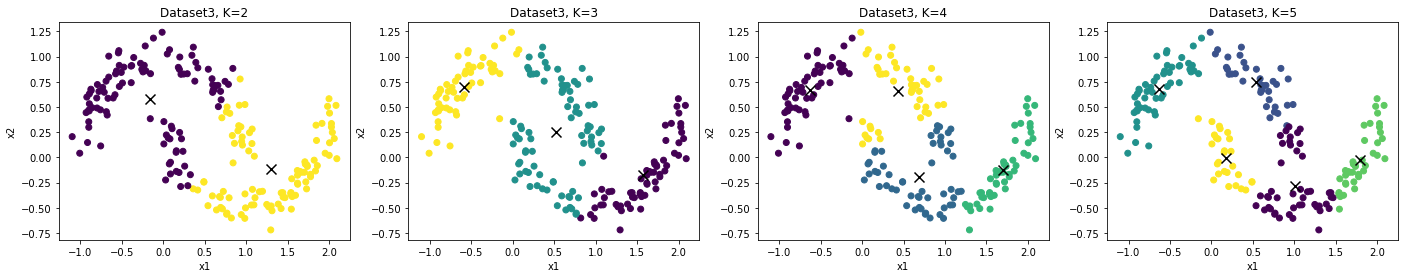

In [494]:
def plot_kmeans(data_dict, results_dict, Ks, colors=['#AA3377', '#009988', '#EE7733', '#0077BB', '#BBBBBB', '#EE3377', '#DDCC77'], shapes=["o", "^", "*", "s", "D"]):    
    """
    visualize the results
    
    """
    for dataset_index, (inputs, true_labels) in data_dict.items():
        fig = plt.figure(figsize=(6*len(Ks),4))
        for i, K in enumerate(Ks):
            means, assignments = results_dict[dataset_index][K]
            ax = fig.add_subplot(1, len(Ks), i+1)
            plt.scatter(inputs[:,0], inputs[:,1], c=assignments)
            
            means=np.array(means).reshape(K,2)
            plt.scatter(means[:,0], means[:,1], c='k', marker='x', s=100)
            ax.set_xlabel('x1', fontsize=10)
            ax.set_ylabel('x2', fontsize=10)
            ax.set_title('Dataset%d, K=%d' % (dataset_index, K))
plot_kmeans(data_dict, results_dict, Ks)

### (EDIT THIS) You may see DBSCAN and K-Means have different performance on these 3 datasets. Find out which algorithm performs better on each of the 3 datasets and explain why. (EDIT THIS)


## Implement Elkan's KMeans Algorithm

In [446]:
import pandas as pd
df = pd.read_csv('kddcup99.csv')

### Extracting labels column

In [447]:
labels = df['label']
df = df.drop('label', 1)

### Finding categorical and numerical features

In [448]:
cat_features = [x for x in df.columns if df[x].dtype == 'object']
num_features = [x for x in df.columns if df[x].dtype != 'object']

### Preprocessing

In [450]:
# Standardizing numerical features
df[num_features] = (df[num_features] - df[num_features].mean())/df[num_features].std()

# Binarizing categorical features
binarized_df = pd.get_dummies(df[cat_features])

### Concatenating the two dataframes

In [451]:
df_final = pd.concat([df[num_features], binarized_df], axis=1)

In [455]:
features = df_final.values

In [495]:
def elkan(inputs, K, maxiter=100, init_means=None):
    # getting initial means 
    if init_means is not None:
        means = init_means
    else:
        # initialize means using KMeans ++
        means = initialize_means(inputs, K)
        
    a = update_assignments(inputs, means, K)
    
    # initializing upper and lower bounds
    l, u = initialize_bounds(inputs, K)
    s = {}
    
    # keeping track of SSE to check for convergence
    SSEs = []
    SSEs.append(compute_sse(inputs, a, means))
    
    for _ in notebook.tqdm(range(maxiter)):
        s = compute_s(means, K)
        
        for i, x in enumerate(inputs):
            if u[tuple(x)] <= s[a[i]]:
                continue
            r=True
            for j in range(K):
                z = max(l[i][j], dist(means[a[i]], means[j])/2)
                if j==a[i] or u[i]<=z:
                    continue
                if r:
                    u[i] = dist(inputs[i], means[a[i]])
                    r = False
                    if u[i]<=z:
                        continue
                
                l[i][j] = dist(inputs[i], means[j])
                if l[i][j] < u[i]:
                    a[i] = j
                    u[i] = l[i][j]
        
        new_means = update_means(inputs, means, a)
        zipped = zip(means, new_means)
        deltas = [dist(x[0], x[1]) for x in zipped]
        
        for i, x in enumerate(inputs):
            u[i] = u[i] + deltas[a[i]]
            for j in range(K):
                l[i][j] = max(0, l[i][j]-deltas[j])
            
        # convergence condition
        if len(SSEs)>=2 and SSEs[-1] == SSEs[-2]:
            break

    return means, a, SSEs[-1]

def compute_s(means, K):
    s = {}
    for i,_ in enumerate(means):
        curr_dist = []
        for j,_ in enumerate(means):
            if i==j:
                continue
            curr_dist.append(dist(means[i], means[j]))
        
        # finding closest center distance / 2
        s[i] = np.min(curr_dist)/2
    
    return s        

def dist(x, y):
    x, y = np.array(x), np.array(y)
    return np.linalg.norm(x-y)

def initialize_means(inputs, K):
    """
    Initializes means based on K-Means++ strategy
    """
    idx = np.random.choice(range(len(inputs)), size=K, replace=False)
    means = [inputs[x] for x in idx]
        
    return means

def initialize_bounds(inputs, K):
    l = defaultdict(lambda: defaultdict(dict))
    u = defaultdict(float)
    for i, x in enumerate(inputs):
        u[tuple(x)] = float('inf')
        for j in range(K):
            l[i][j] = 0
    
    return l, u

In [496]:
# getting initial means to be used for KMeans and Elkan
initial_means = initialize_means(features, 100)

In [498]:
# Run Elkan KMeans
means,a,sse = elkan(features[:1000], 100, init_means=initial_means)

  0%|          | 0/100 [00:00<?, ?it/s]

/Users/harshits/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning:

Mean of empty slice.

/Users/harshits/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars



KeyboardInterrupt: 

In [502]:
# Run KMeans
means,a,sse = K_Means(features[:1000], 100, init_means=initial_means)

<ipython-input-501-1eee2bde6c6e>:101: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



ValueError: operands could not be broadcast together with shapes (118,) (100,) 

In [341]:
inputs = np.array([[0,1],[5,2],[2,3],[6,1],[10,2],[0,6],[3,4],[6,3],[0,7],[7,2],[1,2]])

In [344]:
a = DBSCAN(inputs, math.sqrt(2) , min_points=3)

running with eps = 1.4142135623730951, and min_pts = 3


In [350]:
a

array([ 2,  1,  2,  1, -1, -1,  2,  1, -1,  1,  2])

In [349]:
import plotly.express as px
fig = px.scatter(x=inputs[:,0], y=inputs[:,1], color=a)
fig.show()

In [504]:
C1=[(5,6),(8,7),(7,3)]
C2=[(6,5),(4,5),(9,2),(3,5),(8,4)]

In [508]:
s2 = np.matmul(np.array(C2).T-np.array([[6, 4.2]]).T, (np.array(C2).T-np.array([[6, 4.2]]).T).T)

In [510]:
s2

array([[ 26. , -11. ],
       [-11. ,   6.8]])

In [363]:
np.array(C2).T- np.array([[6, 4.2]]).T

array([[ 0. , -2. ,  3. , -3. ,  2. ],
       [ 0.8,  0.8, -2.2,  0.8, -0.2]])

In [365]:
s2 = np.cov(np.array(C2).T- np.array([[6, 4.2]]).T)

In [384]:
a=np.matmul(np.array([[-0.25, -0.42]]).T, np.array([[-0.25, -0.42]]))*5
b=np.matmul(np.array([[0.41, 0.7]]).T, np.array([[0.41, 0.7]]))*3

In [521]:
from sklearn.cluster import AgglomerativeClustering

In [514]:
import numpy as np
coords = []
for i in range(10):
    for j in range(10):
        coords.append((i,j))

[(7, 3), (1, 0), (9, 2), (6, 5), (5, 0)]
[4 2 3 1 0]
[4 3 1 2 0]
[4 3 2 1 0]


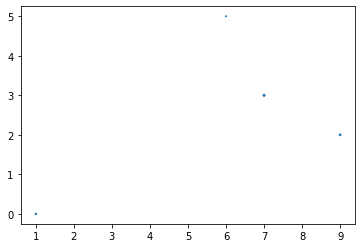

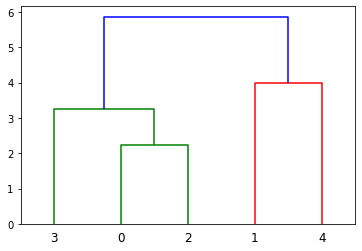

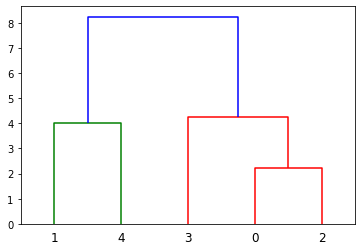

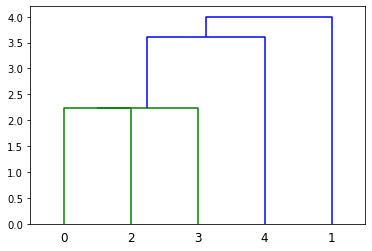

In [552]:
while True:
    points_idx = np.random.choice(range(len(coords)), size=5)
    points = [coords[x] for x in points_idx]
    
    clustering1 = AgglomerativeClustering(linkage='average', distance_threshold=0, n_clusters=None).fit(points)
    clustering2 = AgglomerativeClustering(linkage='complete', distance_threshold=0, n_clusters=None).fit(points)
    clustering3 = AgglomerativeClustering(linkage='single', distance_threshold=0, n_clusters=None).fit(points)
    
    if list(clustering1.labels_)!= list(clustering2.labels_) and \
        list(clustering2.labels_) != list(clustering3.labels_) and \
        list(clustering3.labels_) != list(clustering1.labels_):
        print(points)
    else:
        continue
    
    print(clustering1.labels_)
    print(clustering2.labels_)
    print(clustering3.labels_)
    
    plt.scatter(np.array(points)[:,0], np.array(points)[:,1], clustering1.labels_)
    plt.show()
    plot_dendrogram(clustering1)#, truncate_mode=None, p=None)
    plt.show()
    plot_dendrogram(clustering2)#, truncate_mode=None, p=None)
    plt.show()
    plot_dendrogram(clustering3)#, truncate_mode=None, p=None)
    plt.show()
    
    break

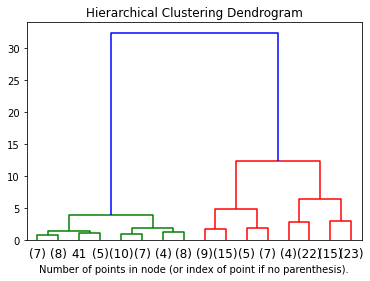

In [553]:
import numpy as np

from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.datasets import load_iris
from sklearn.cluster import AgglomerativeClustering


def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
model = model.fit(X)
plt.title('Hierarchical Clustering Dendrogram')
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode='level', p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

In [556]:
linkage(points, method='average')

array([[0.        , 2.        , 2.23606798, 2.        ],
       [3.        , 5.        , 3.23935433, 3.        ],
       [1.        , 4.        , 4.        , 2.        ],
       [6.        , 7.        , 5.86703162, 5.        ]])